# Two Dimensional Point Landing
The dynamics of the system are:
$$
\left \{
\begin{align}
\dot{x} &= v_x \\
\dot{y} &= v_y \\
\dot{v}_x &= \frac{T u}{m} \hat{u}_x \\
\dot{v}_y &= \frac{T u}{m} \hat{u}_y - g\\
\dot{m} &= -\frac{T}{I_{sp}g_0}
\end{align}
\right\}
$$

In [1]:
from sympy import *

In [2]:
# State
x, y, vx, vy, m = symbols('x y vx vy m')
r = Matrix([x, y])
v = Matrix([vx, vy])
s = Matrix([r, v, [m]])

# Costate
lx, ly, lvx, lvy, lm = symbols('lx ly lvx lvy lvm')
lr = Matrix([lx, ly])
lv = Matrix([lvx, lvy])
l  = Matrix([lr, lv, [lm]])

# Fullstate
fs = Matrix([s, l])

# Control
u, st, ct = symbols('u st ct')
ut = Matrix([st, ct])
cont = Matrix([[u], ut])

# Parameters
T, Isp, g0, a = symbols('T Isp g0 a')
c = Isp*g0
g = Matrix([0, -g0])

In [3]:
# Dynamics
dr = v
dv = T*u/m*ut + g
dm = -T/c*u
ds = Matrix([dr, dv, [dm]])

In [4]:
# Lagrangian Cost
L = 1/c*((1-a)*T**2*u**2 + a*T*u)

In [5]:
# Hamiltonian
H = l.dot(ds) + L

In [6]:
# Costate Dynamics
dl = -Matrix([H.diff(i) for i in s])

In [7]:
# Fullstate dynamics
dfs = Matrix([ds, dl])
ds

Matrix([
[           vx],
[           vy],
[     T*st*u/m],
[T*ct*u/m - g0],
[-T*u/(Isp*g0)]])

# Implementation

In [8]:
import sys
sys.path.append('../')
from trajectory.landing import PointLander
# Use European Space Agency's PyGMO
from PyGMO import *

In [9]:
# Instantiate the lander with Hermite-Simpson mass optimal control
Apollo = PointLander(meth='HS', obj='mass', nseg=10)

In [10]:
# Use sequentual least square quadratic programming
algo = algorithm.scipy_slsqp(max_iter=10, screen_output=True)
algo = algorithm.mbh(algo, screen_output=True)

In [11]:
for i in range(1, 10):
    print("Attempt", i)
    pop = population(Apollo, 1)
    pop = algo.evolve(pop)
    print(algo)
    print("Constraint", pop[0].cur_c)
    if Apollo.feasibility_x(pop[0].cur_x):
        print("Success")
        break
    else:
        print("Retrying")

('Attempt', 1)
  NIT    FC           OBJFUN            GNORM
    1   121    -8.046306E+03     1.000000E+00
    2   242    -8.047306E+03     1.000000E+00
    3   363    -8.052305E+03     1.000000E+00
    4   484    -8.077268E+03     1.000000E+00
    5   605    -8.201258E+03     1.000000E+00
    6   726    -8.771827E+03     1.000000E+00
    7   847    -1.000000E+04     1.000000E+00
    8   969    -9.773038E+03     1.000000E+00
    9  1090    -9.903555E+03     1.000000E+00
   10  1211    -9.262190E+03     1.000000E+00
   11  1332    -9.585493E+03     1.000000E+00
Iteration limit exceeded    (Exit mode 9)
            Current function value: -9585.49310453
            Iterations: 11
            Function evaluations: 1332
            Gradient evaluations: 11
  NIT    FC           OBJFUN            GNORM
    1   121    -9.330720E+03     1.000000E+00
    2   242    -9.331718E+03     1.000000E+00
    3   363    -9.332718E+03     1.000000E+00
    4   484    -9.333454E+03     1.000000E+00
    5  

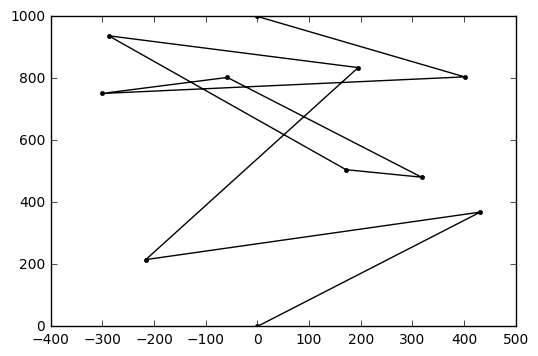

In [12]:
Apollo.PlotTraj(pop.champion.x)